In [1]:
import os, sys, configparser, logging, argparse
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES']='2'

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.util import init_params
from XAE.sampler import gaus

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
z_dim = 4

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, z_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(z_dim),
    nn.ReLU(True),
    nn.Linear(z_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [4]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('/home/reddragon/data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [5]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*z_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [6]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
lamb = 1.0

running_loss = 0.0
for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        #z = gaus(n, z_dim, device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
#         mmd = (kk(xx,xx, False) + kk(z,z, False))/(n*(n-1)) - 2*kk(xx,z, True)/(n*n)
        loss = crit(output, y) #+ lamb * mmd
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.673
[2] loss: 0.655
[3] loss: 0.263
[4] loss: 0.129
[5] loss: 0.077
[6] loss: 0.051
[7] loss: 0.038
[8] loss: 0.024
[9] loss: 0.018
[10] loss: 0.016
[11] loss: 0.013
[12] loss: 0.011
[13] loss: 0.010
[14] loss: 0.009
[15] loss: 0.008
[16] loss: 0.006
[17] loss: 0.004
[18] loss: 0.005
[19] loss: 0.006
[20] loss: 0.005


In [117]:
torch.save(embed_data.state_dict(), 'embed_data_weight.pt')
torch.save(embed_condition.state_dict(), 'embed_condition_weight.pt')

In [3]:
embed_data.load_state_dict(torch.load('embed_data_weight.pt'))
embed_condition.load_state_dict(torch.load('embed_condition_weight.pt'))

<All keys matched successfully>

In [4]:
import numpy as np

In [9]:
from XAE.dataset import MNIST
batch_size = 100
test_data = MNIST('/home/reddragon/data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [10]:
a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 4])

In [11]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, 4))

In [12]:
i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break

In [13]:
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

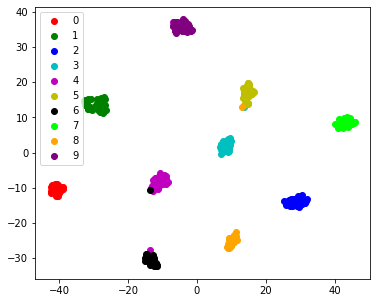

In [15]:
target_ids = range(10)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

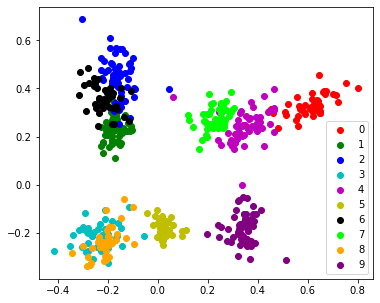

In [16]:
target_ids = range(10)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [ ]:
for i in range(5):
    a, b = next(iter(test_generator))
    embed_condition(embed_data(a.to(device))).shape

In [8]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('/home/reddragon/data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [9]:
zs = np.zeros((10, z_dim))
cs = np.zeros(10)

In [10]:
for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, z_dim)
    cc = torch.zeros((10, z_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    zs += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()

In [19]:
w = torch.Tensor(zs.transpose()/cs)
w

tensor([[ 0.5737, -0.1650, -0.1574, -0.2385,  0.3683,  0.0229, -0.2029,  0.2337,
         -0.2031,  0.3703],
        [-0.2053,  0.3506, -0.1765,  0.3934,  0.3973, -0.1349,  0.2740, -0.0954,
         -0.1702,  0.3613],
        [ 0.3207,  0.2618,  0.4350, -0.2106,  0.2585, -0.1697,  0.3638,  0.3000,
         -0.2340, -0.1708],
        [-0.2444,  0.4899, -0.0479, -0.0116, -0.1235, -0.1772, -0.2298,  0.5017,
          0.4539,  0.4427]])

In [29]:
f1 = nn.Linear(10, z_dim, bias = False)
f1.weight.data = w

In [35]:
torch.save(f1.state_dict(), 'f1.pt')